<a href="https://colab.research.google.com/github/Gowtham7888/personalized_recommandation_system/blob/main/Personalized_recommandation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downgrade numpy and reinstall surprise in a clean way
!pip uninstall -y scikit-surprise
!pip install numpy==1.24.4
!pip install scikit-surprise --no-binary :all:


  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469546 sha256=b8ff3c063233c235ce728bdff105bb51cc2555bd89964f8572d5b989f2dc8b08
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import zipfile
import io
import requests
from collections import defaultdict

In [3]:
def download_movielens_data():
    """Download and extract MovieLens 100k dataset"""
    print("Downloading MovieLens data...")
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    response = requests.get(url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall("ml-100k")

    # Load the data
    ratings = pd.read_csv(
        'u.data',
        sep='\t',
        names=['user_id', 'movie_id', 'rating', 'timestamp']
    )

    movies = pd.read_csv(
        'u.item',
        sep='|',
        encoding='latin-1',
        header=None,
        usecols=[0, 1, 2] + list(range(5, 24)),
        names=['movie_id', 'title', 'release_date'] + [
            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
        ]
    )

    print(f"Loaded {len(ratings)} ratings and {len(movies)} movies")
    return ratings, movies

ratings, movies = download_movielens_data()

Loaded 100000 ratings and 1682 movies


In [4]:
def preprocess_data(ratings, movies):
    """Clean and prepare the data"""
    print("\nPreprocessing data...")

    # Extract year from title
    movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)')
    movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

    # Create genre string
    genre_cols = movies.columns[4:]
    movies['genres'] = movies[genre_cols].apply(
        lambda x: '|'.join(x.index[x == 1]), axis=1
    )

    # Filter movies with no release year
    movies = movies.dropna(subset=['release_year'])

    # Normalize ratings
    ratings['rating_norm'] = (ratings['rating'] - ratings['rating'].min()) / \
                           (ratings['rating'].max() - ratings['rating'].min())

    # Filter sparse users and items
    min_ratings = 20
    user_counts = ratings['user_id'].value_counts()
    movie_counts = ratings['movie_id'].value_counts()

    ratings = ratings[ratings['user_id'].isin(user_counts[user_counts >= min_ratings].index)]
    ratings = ratings[ratings['movie_id'].isin(movie_counts[movie_counts >= min_ratings].index)]

    # Merge data
    merged = pd.merge(ratings, movies[['movie_id', 'title', 'genres', 'release_year']], on='movie_id')

    print(f"Final dataset contains {len(merged)} ratings from {merged['user_id'].nunique()} users on {merged['movie_id'].nunique()} movies")
    return merged, movies

merged, movies = preprocess_data(ratings, movies)


Preprocessing data...
Final dataset contains 94968 ratings from 943 users on 939 movies



Performing EDA...


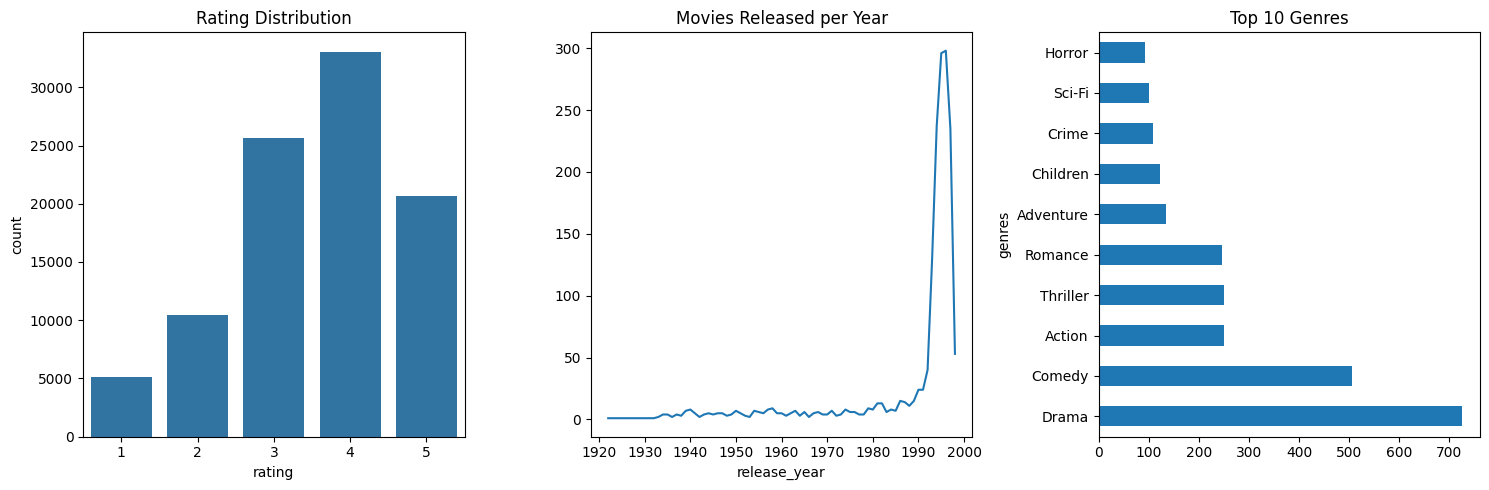

In [5]:
# STEP 3: EXPLORATORY DATA ANALYSIS
# -------------------------------
def perform_eda(merged, movies):
    """Visualize key aspects of the dataset"""
    print("\nPerforming EDA...")

    plt.figure(figsize=(15, 5))

    # Rating distribution
    plt.subplot(1, 3, 1)
    sns.countplot(x='rating', data=merged)
    plt.title('Rating Distribution')

    # Movies per year
    plt.subplot(1, 3, 2)
    movies['release_year'].value_counts().sort_index().plot()
    plt.title('Movies Released per Year')

    # Top genres
    plt.subplot(1, 3, 3)
    movies['genres'].str.split('|').explode().value_counts().head(10).plot(kind='barh')
    plt.title('Top 10 Genres')

    plt.tight_layout()
    plt.show()

perform_eda(merged, movies)

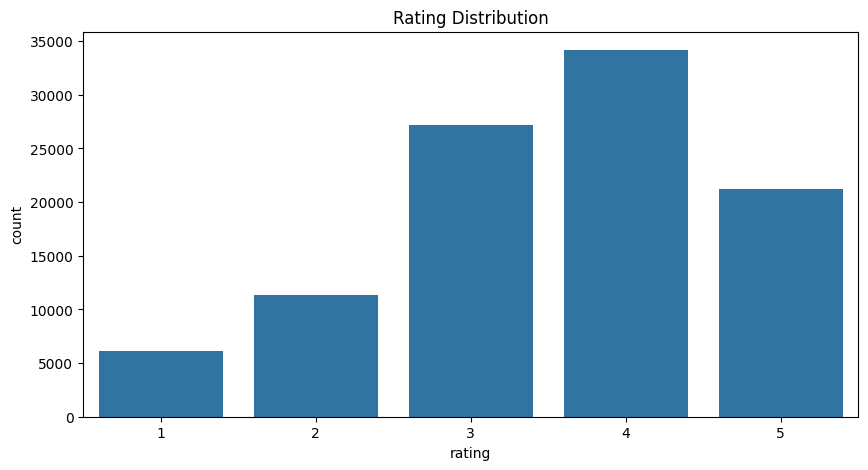

     movie_id                          title release_date  unknown  Action  \
0           1               Toy Story (1995)  01-Jan-1995        0       0   
49         50               Star Wars (1977)  01-Jan-1977        0       1   
99        100                   Fargo (1996)  14-Feb-1997        0       0   
120       121  Independence Day (ID4) (1996)  03-Jul-1996        0       1   
180       181      Return of the Jedi (1983)  14-Mar-1997        0       1   
257       258                 Contact (1997)  11-Jul-1997        0       0   
285       286    English Patient, The (1996)  15-Nov-1996        0       0   
287       288                  Scream (1996)  20-Dec-1996        0       0   
293       294               Liar Liar (1997)  21-Mar-1997        0       0   
299       300           Air Force One (1997)  01-Jan-1997        0       1   

     Adventure  Animation  Children  Comedy  Crime  ...  Horror  Musical  \
0            0          1         1       1      0  ...       0  

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
plt.figure(figsize=(10,5))
sns.countplot(x='rating', data=ratings)
plt.title('Rating Distribution')
plt.show()

# Top 10 most rated movies
top_movies = ratings['movie_id'].value_counts().head(10)
print(movies[movies['movie_id'].isin(top_movies.index)])

In [7]:
# STEP 4: BUILD RECOMMENDATION MODELS
# -------------------------------
def build_models(merged, movies):
    """Build collaborative and content-based models"""
    print("\nBuilding recommendation models...")

    # Collaborative Filtering with SVD
    print("Training SVD model...")
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(merged[['user_id', 'movie_id', 'rating_norm']], reader)
    trainset, testset = train_test_split(data, test_size=0.2)

    svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)
    svd.fit(trainset)
    predictions = svd.test(testset)

    # Evaluate SVD
    print("\nSVD Model Evaluation:")
    accuracy.rmse(predictions)
    accuracy.mae(predictions)

    # Content-Based Filtering
    print("\nBuilding content-based model...")
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies['genres'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

    return {
        'svd': svd,
        'cosine_sim': cosine_sim,
        'indices': indices,
        'movies': movies,
        'merged': merged
    }

models = build_models(merged, movies)


Building recommendation models...
Training SVD model...

SVD Model Evaluation:
RMSE: 0.2372
MAE:  0.1870

Building content-based model...


In [8]:
# STEP 5: RECOMMENDATION FUNCTIONS
def get_content_recommendations(title, models, n=5):
    """Content-based recommendations"""
    idx = models['indices'][title]
    sim_scores = list(enumerate(models['cosine_sim'][idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Skip the movie itself
    movie_indices = [i[0] for i in sim_scores]
    return models['movies'].iloc[movie_indices][['title', 'genres']]

def get_collab_recommendations(user_id, models, n=5):
    """Collaborative filtering recommendations"""
    # Get all movie IDs
    all_movie_ids = models['merged']['movie_id'].unique()

    # Get movies user hasn't rated
    rated_movies = models['merged'][models['merged']['user_id'] == user_id]['movie_id']
    unrated = [m for m in all_movie_ids if m not in rated_movies]

    # Predict ratings
    predictions = []
    for movie_id in unrated:
        pred = models['svd'].predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))

    # Get top n recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movies = [m[0] for m in predictions[:n]]

    return models['movies'][models['movies']['movie_id'].isin(top_movies)][['title', 'genres']]

def hybrid_recommend(user_id, title, models, n=5):
    """Hybrid recommendations combining both approaches"""
    # First get content-based recommendations
    content_recs = get_content_recommendations(title, models, n=20)
    content_recs = pd.merge(
        content_recs,
        models['movies'][['movie_id', 'title']],
        on='title'
    )

    # Then score them using collaborative filtering
    content_recs['est_rating'] = content_recs['movie_id'].apply(
        lambda x: models['svd'].predict(user_id, x).est
    )

    # Return top n recommendations
    top_recs = content_recs.sort_values('est_rating', ascending=False).head(n)
    return top_recs[['title', 'genres', 'est_rating']]

ratings['rating_norm'] = ratings['rating'] / 5.0

# Rebuild training data
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating_norm']], reader)
trainset = data.build_full_trainset()

# Refit the model
models['svd'].fit(trainset)


In [9]:
# STEP 6: TEST THE SYSTEM
# -------------------------------
print("\nTesting the recommendation system...")

# Example collaborative recommendations
print("\nCollaborative recommendations for user 2:")
print(get_collab_recommendations(2, models))

# Example content-based recommendations
print("\nContent-based recommendations similar to 'Toy Story (1995)':")
print(get_content_recommendations('Toy Story (1995)', models))

# Example hybrid recommendations
print("\nHybrid recommendations for user 1 who liked 'Toy Story (1995)':")
print(hybrid_recommend(1, 'Toy Story (1995)', models))


Testing the recommendation system...

Collaborative recommendations for user 2:
                                                 title  \
113  Wallace & Gromit: The Best of Aardman Animatio...   
177                                12 Angry Men (1957)   
478                                     Vertigo (1958)   
479                          North by Northwest (1959)   
655                                           M (1931)   

                       genres  
113                 Animation  
177                     Drama  
478          Mystery|Thriller  
479           Comedy|Thriller  
655  Crime|Film-Noir|Thriller  

Content-based recommendations similar to 'Toy Story (1995)':
                                      title                     genres
421  Aladdin and the King of Thieves (1996)  Animation|Children|Comedy
101                  Aristocats, The (1970)         Animation|Children
403                        Pinocchio (1940)         Animation|Children
624          Sword in the Stone,

In [10]:
from google.colab import files
uploaded = files.upload()


In [11]:
from google.colab import files
uploaded = files.upload()

In [12]:
!pip install streamlit pyngrok scikit-learn surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.5 MB/s eta 0:00:00


In [13]:
!ngrok config add-authtoken 2yGzPD2ueyI6dRtzjJTmrDCm4Jc_7efPCSEVNSidqRPUmxYZa

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [14]:
code = """
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD, Dataset, Reader

def load_data():
    movies = pd.read_csv('/content/movies.dat', encoding='latin-1', sep='::', engine='python', names=['movieId', 'title', 'genres'])
    ratings = pd.read_csv('/content/ratings.dat', encoding='latin-1', sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])
    ratings['rating_norm'] = ratings['rating'] / 5.0
    return movies, ratings

def build_models(movies, ratings):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating_norm']], reader)
    trainset = data.build_full_trainset()
    svd = SVD()
    svd.fit(trainset)

    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

    return {
        'svd': svd,
        'cosine_sim': cosine_sim,
        'indices': indices,
        'movies': movies,
        'ratings': ratings
    }

def get_content_recommendations(title, models, n=5):
    idx = models['indices'].get(title)
    if idx is None:
        return pd.DataFrame()
    sim_scores = list(enumerate(models['cosine_sim'][idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return models['movies'].iloc[movie_indices][['title', 'genres']]

def get_collab_recommendations(userId, models, n=5):
    all_movie_ids = models['movies']['movieId'].unique()
    rated = models['ratings'][models['ratings']['userId'] == userId]['movieId']
    unrated = [m for m in all_movie_ids if m not in rated.values]

    predictions = [(m, models['svd'].predict(userId, m).est) for m in unrated]
    predictions.sort(key=lambda x: x[1], reverse=True)
    top = [m[0] for m in predictions[:n]]
    return models['movies'][models['movies']['movieId'].isin(top)][['title', 'genres']]

def hybrid_recommend(userId, title, models, n=5):
    content_recs = get_content_recommendations(title, models, n=20)
    if content_recs.empty:
        return content_recs
    content_recs = pd.merge(
        content_recs,
        models['movies'][['movieId', 'title']],
        on='title'
    )
    content_recs['est_rating'] = content_recs['movieId'].apply(lambda x: models['svd'].predict(userId, x).est)
    top = content_recs.sort_values('est_rating', ascending=False).head(n)
    return top[['title', 'genres', 'est_rating']]
"""

with open("model_utils.py", "w") as f:
    f.write(code)


In [15]:
app_code = """
import streamlit as st
from model_utils import load_data, build_models, get_content_recommendations, get_collab_recommendations, hybrid_recommend

st.set_page_config(page_title="🎬Personalized Movie Recommendation Dashboard", layout="centered")
st.title("🎬 Movie Recommendation System")

with st.spinner("Loading data and building models..."):
    movies, ratings = load_data()
    models = build_models(movies, ratings)

option = st.selectbox("Choose recommendation type:", ["Content-Based", "Collaborative", "Hybrid"])

if option == "Content-Based":
    movie = st.selectbox("Select a movie:", movies['title'].unique())
    if st.button("Recommend"):
        recs = get_content_recommendations(movie, models)
        st.subheader("🎯 Recommendations based on genres")
        st.table(recs)

elif option == "Collaborative":
    userId = st.number_input("Enter User ID:", min_value=1, value=1)
    if st.button("Recommend"):
        recs = get_collab_recommendations(userId, models)
        st.subheader("👥 Recommendations based on user behavior")
        st.table(recs)

elif option == "Hybrid":
    userId = st.number_input("Enter User ID:", min_value=1, value=1)
    movie = st.selectbox("Select a movie:", movies['title'].unique())
    if st.button("Recommend"):
        recs = hybrid_recommend(userId, movie, models)
        st.subheader("🔀 Hybrid Recommendations")
        st.table(recs)
"""
with open("app.py", "w") as f:
    f.write(app_code)


In [16]:
from pyngrok import ngrok
import threading
import time
import os

# Run Streamlit in a separate thread
def run_streamlit():
    os.system('streamlit run app.py')

thread = threading.Thread(target=run_streamlit)
thread.start()

# Wait for the server to launch
time.sleep(5)

# Connect to port 8501 using ngrok
public_url = ngrok.connect(8501)
print(f"🌍 Your app is live at: {public_url}")


🌍 Your app is live at: NgrokTunnel: "https://d0bc-34-16-168-42.ngrok-free.app" -> "http://localhost:8501"
